In [80]:
import pandas as pd
import numpy as np
import warnings
import json
warnings.filterwarnings('ignore')

# Import các utils đã cập nhật
import utils.data_utils as du
import utils.feature_utils as fu
import utils.preparation_utils as pu
import utils.model_utils as mu
import utils.viz_utils as vu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load

In [81]:
print("=== BẮT ĐẦU PIPELINE ===")

print("\nLoading & Feature Engineering...")
tables = du.load_olist_tables(
    data_path='data',
    tables_to_load=['orders', 'order_items', 'order_reviews', 'products',
                    'sellers', 'customers', 'geolocation', 'product_category'],
    verbose=False
)

df_base = du.create_base_dataset(tables, merge_strategy='left')
df = du.filter_by_conditions(df_base, {'order_status': ['delivered']}, verbose=False)
df = df[df['review_score'].notna()].copy()

=== BẮT ĐẦU PIPELINE ===

Loading & Feature Engineering...
Creating base dataset...
Starting with orders: (99441, 8)
After merge reviews: (99992, 11)
After merge order_items: (99992, 16)
After merge customers: (99992, 19)
After merge sellers: (99992, 22)
After merge products: (99992, 29)
After merge category translation: (99992, 30)

✓ Base dataset created: (99992, 30)


In [82]:
# Tạo Features
# 1. Stateless Features (Chạy thoải mái trên toàn bộ hoặc từng tập)
df = fu.process_datetime_features(df)
df = fu.process_geo_features(df, tables['geolocation'])
df = fu.process_product_pricing(df)
df = fu.create_target(df) # Tạo nhãn

In [83]:
# Load review table riêng
reviews_df = tables['order_reviews']
df = fu.process_dynamic_seller_features(df, reviews_df, window_days=60)

Generating Dynamic Seller Features (Window: 60 days)...


In [84]:
# ---------------------------------------------------------
# CHIA TRAIN_FULL / TEST (Strict Temporal Split)
# ---------------------------------------------------------
print("\n Splitting Data (Train_full / Test)...")

train_df, test_df, _ = du.temporal_split(
    df,
    date_col='order_purchase_timestamp',
    test_size=0.2
)


 Splitting Data (Train_full / Test)...
Temporal split at: 2018-05-26 13:17:52
Train: (77088, 45) (2016-09-15 12:16:38 to 2018-05-26 13:12:54)
Test:  (19273, 45) (2018-05-26 13:17:52 to 2018-08-29 15:00:37)


In [85]:
# 3. Stateful Features (Học từ Train -> Map sang Test)
# --- A. Seller History ---
seller_stats_lookup = fu.fit_seller_history(train_df)
train_df = fu.transform_seller_history(train_df, seller_stats_lookup)
test_df = fu.transform_seller_history(test_df, seller_stats_lookup)

[fit_seller_history] rows=77088, sellers=2416, global_mean=0.2221, C=10
[transform_seller_history] merged=77088 rows, missing_seller_risk=0
[transform_seller_history] merged=19273 rows, missing_seller_risk=2562


In [86]:
# --- B. Route History ---
route_stats_lookup = fu.fit_route_stats(train_df)
train_df = fu.transform_route_stats(train_df, route_stats_lookup)
test_df = fu.transform_route_stats(test_df, route_stats_lookup)

[fit_route_stats] valid_rows=77086
[fit_route_stats] routes_computed=391
[transform_route_stats] merged=77088 rows, missing_route_stats=0
[transform_route_stats] merged=19273 rows, missing_route_stats=27


# Preprocessing

In [87]:
# ============================================================================
# DEFINING FEATURE GROUPS (Định nghĩa các nhóm biến)
# ============================================================================
# A. Các biến định lượng bị lệch (Skewed) -> Cần Log Transform + Scaling
# Lưu ý: Các biến _log tạo ở feature_utils rồi thì đưa vào Normal, biến gốc thì đưa vào đây
skewed_cols = [
    'total_price',
    'total_freight',
    'distance_km',
    'gap_promise_vs_reality', # Chênh lệch giữa Olist hứa và lịch sử thực tế
    'product_weight_g'
]

# B. Các biến định lượng phân phối chuẩn/đã đẹp (Normal) -> Cần Standard Scaling
# Bao gồm cả các biến đã log-transform ở bước trước (nếu có)
normal_cols = [
    'seller_risk_score',       # Đã smooth bằng Bayesian
    'route_median_days',       # Median lịch sử tuyến đường
    'product_photos_qty',
    'product_description_lenght',
    'freight_ratio',
    'weight_log',              # <--- Mới thêm: Bản thân nó là log của weight
    'route_std_days',          # <--- Mới thêm: Độ lệch chuẩn của tuyến đường
    'product_length_cm',       # <--- Mới thêm: Kích thước
    'product_height_cm',       # <--- Mới thêm
    'product_width_cm'
]

# C. Các biến phân loại (Categorical) -> Cần Label Encoding
categorical_cols = [
    'customer_state',
    'seller_state',
    'product_category_name_english',
    'product_category_name',   # <--- Mới thêm: Tên gốc tiếng Bồ Đào Nha (phòng khi tiếng Anh thiếu)
    'payment_type'             # Nếu có trong bảng order_payments
]

# D. Các cột cần loại bỏ (IDs, Date gốc, Text, Target)
# Giữ lại 'target' trong y, nhưng loại khỏi X
cols_to_drop = [
    'order_id', 'customer_id', 'order_item_id', 'product_id', 'seller_id',
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_comment_title', 'review_comment_message', 'review_creation_date',
    'review_answer_timestamp', 'review_id',
    'customer_city', 'seller_city',
    'order_status',
    'review_score',
    'review_creation_date_x', 'review_creation_date_y'

]

In [88]:
# ============================================================================
# PREPROCESSING PIPELINE (Learn from Train -> Apply to Test)
# ============================================================================
print("\n=== STARTING PREPROCESSING PIPELINE ===")
# --- BƯỚC 1: Tách X và y ---
# (Lưu ý: train_df và test_df lúc này đã có đủ feature từ bước trước)
# Xử lý Train
X_train_raw = train_df.drop(columns=['target'] + cols_to_drop, errors='ignore')
y_train = train_df['target']

# Xử lý Test
X_test_raw = test_df.drop(columns=['target'] + cols_to_drop, errors='ignore')
y_test = test_df['target']

print(f"Input Shape - Train: {X_train_raw.shape}, Test: {X_test_raw.shape}")


=== STARTING PREPROCESSING PIPELINE ===
Input Shape - Train: (77088, 37), Test: (19273, 37)


In [89]:
# TRAINING PIPELINE (Fit & Transform trên Train) ---
print("\n--- Processing Train Set ---")
X_train_processed, artifacts = pu.train_preparation_pipeline(
    X_train_raw,
    skewed_cols=skewed_cols,
    normal_cols=normal_cols,
    categorical_cols=categorical_cols,
    top_n_categories=25
)


--- Processing Train Set ---
  [1/5] Fitting Imputer...
  [2/5] Fitting Outlier Capper...
  [3/5] Applying Log Transform...
  [4/5] Checking Multicollinearity...
  -> Detected multicollinearity. Dropping: ['weight_log']
  [5/5] Fitting Scaler...
  [6/6] Encoding Categoricals...
  -> Grouping 'customer_state': Reduced 27 categories to 25 + 'Other'
  -> Grouping 'product_category_name_english': Reduced 71 categories to 25 + 'Other'
  -> Grouping 'product_category_name': Reduced 73 categories to 25 + 'Other'


In [90]:
# TESTING PIPELINE (Transform Test bằng Artifacts của Train) ---
print("\n--- Processing Test Set (Using Train Artifacts) ---")
X_test_processed = pu.test_preparation_pipeline(
    X_test_raw,
    artifacts=artifacts, # <--- CHÌA KHÓA CHỐNG LEAKAGE
    skewed_cols=skewed_cols,
    categorical_cols=categorical_cols
)


--- Processing Test Set (Using Train Artifacts) ---


In [91]:
# ============================================================================
# VERIFICATION & SAVING
# ============================================================================
print("\n=== VERIFICATION ===")
# Kiểm tra xem còn NaN không
n_nan_train = X_train_processed.isna().sum().sum()
n_nan_test = X_test_processed.isna().sum().sum()
print(f"Remaining NaNs - Train: {n_nan_train}, Test: {n_nan_test}")

# Kiểm tra shape cuối cùng
print(f"Final Shape - Train: {X_train_processed.shape}, Test: {X_test_processed.shape}")

# Lưu Artifacts (Quan trọng để Deploy sau này)
import joblib
joblib.dump(artifacts, 'models/preprocessing_artifacts.pkl')
print("✓ Artifacts saved to 'models/preprocessing_artifacts.pkl'")




=== VERIFICATION ===
Remaining NaNs - Train: 0, Test: 0
Final Shape - Train: (77088, 36), Test: (19273, 36)
✓ Artifacts saved to 'models/preprocessing_artifacts.pkl'


In [92]:
# Lưu một mẫu dữ liệu Test để App chạy Demo
X_test_raw.sample(100, random_state=42).to_csv('data/sample_data.csv', index=False)
X_test_raw.sample(100, random_state=1).to_csv('data/sample_data_1.csv', index=False)
X_test_raw.sample(100, random_state=2).to_csv('data/sample_data_2.csv', index=False)
X_test_raw.sample(100, random_state=3).to_csv('data/sample_data_3.csv', index=False)

print("✓ Saved sample data for App Demo")


✓ Saved sample data for App Demo


In [93]:
# ============================================================================
# SANITY CHECK & FINAL CLEANING
# ============================================================================
print("=== SANITY CHECK INPUT DATA ===")
# Kiểm tra còn object columns không
obj_cols = X_train_processed.select_dtypes(include='object').columns.tolist()
if len(obj_cols) > 0:
    raise ValueError(f"CRITICAL: Still have object columns: {obj_cols}. Please fix encoding.")
else:
    print("✓ Data types are clean (Numeric/Int). Ready for training.")

=== SANITY CHECK INPUT DATA ===
✓ Data types are clean (Numeric/Int). Ready for training.


# Training

In [94]:
# ============================================================================
# 1. BASELINE SELECTION
# ============================================================================
print("\n=== RUNNING BASELINE COMPARISON ===")
baseline_results = mu.compare_baselines(X_train_processed, y_train, n_splits=5)

print("\nBaseline Leaderboard:")
print(baseline_results[['Model', 'roc_auc', 'f2', 'f1', 'recall']])

best_model_name = baseline_results.iloc[0]['Model']
print(f"\n-> WINNER: {best_model_name}")


=== RUNNING BASELINE COMPARISON ===

Evaluating LogisticRegression with 5-fold TimeSeriesSplit...
  Fold 1: AUC=0.6380 | F1=0.3488
  Fold 2: AUC=0.6672 | F1=0.4144
  Fold 3: AUC=0.6658 | F1=0.4215
  Fold 4: AUC=0.6846 | F1=0.5047
  Fold 5: AUC=0.6810 | F1=0.4010
  -> Mean AUC: 0.6673 | Mean F2: 0.4963

Evaluating RandomForest with 5-fold TimeSeriesSplit...
  Fold 1: AUC=0.6161 | F1=0.2869
  Fold 2: AUC=0.6585 | F1=0.3914
  Fold 3: AUC=0.6627 | F1=0.4008
  Fold 4: AUC=0.6792 | F1=0.4746
  Fold 5: AUC=0.6864 | F1=0.3952
  -> Mean AUC: 0.6606 | Mean F2: 0.4183

Evaluating LightGBM with 5-fold TimeSeriesSplit...
  Fold 1: AUC=0.5877 | F1=0.2229
  Fold 2: AUC=0.6325 | F1=0.2994
  Fold 3: AUC=0.6428 | F1=0.3726
  Fold 4: AUC=0.6562 | F1=0.4345
  Fold 5: AUC=0.6809 | F1=0.3752
  -> Mean AUC: 0.6400 | Mean F2: 0.3396

Baseline Leaderboard:
                Model   roc_auc        f2        f1    recall
0  LogisticRegression  0.667309  0.496340  0.418093  0.572643
1        RandomForest  0.660593

In [95]:
# ============================================================================
# 2. SECONDARY SPLIT (Train_Sub / Validation)
# ============================================================================
print("\n=== SECONDARY SPLIT FOR TUNING & CALIBRATION ===")


val_size = int(len(X_train_processed) * 0.15)
train_sub_size = len(X_train_processed) - val_size

# Cắt theo index (vì data đã sort theo thời gian từ Phase 1)
X_train_sub = X_train_processed.iloc[:train_sub_size]
y_train_sub = y_train.iloc[:train_sub_size]

X_val = X_train_processed.iloc[train_sub_size:]
y_val = y_train.iloc[train_sub_size:]

print(f"Train Sub: {X_train_sub.shape} (Used for Hyperparameter Tuning)")
print(f"Validation: {X_val.shape} (Used for Calibration & Threshold)")


=== SECONDARY SPLIT FOR TUNING & CALIBRATION ===
Train Sub: (65525, 36) (Used for Hyperparameter Tuning)
Validation: (11563, 36) (Used for Calibration & Threshold)


In [96]:
# ============================================================================
# 3 & 4. TUNING & RETRAINING
# ============================================================================
print(f"\n=== HYPERPARAMETER TUNING ({best_model_name}) ===")

final_model = None

if 'LightGBM' in best_model_name:
    # Dùng Optuna cho LightGBM
    final_model = mu.tune_lgbm_optuna(
        X_train_sub, y_train_sub,
        n_trials=30,        # Số lần thử nghiệm
        n_splits=3,         # CV folds
        time_limit=300      # Giới hạn 5 phút (demo), thực tế nên để 600-1200s
    )

else:

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    if 'RandomForest' in best_model_name:
        base_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
        }
    else: # LogisticRegression
        base_model = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
        param_grid = {
            'C': np.logspace(-4, 4, 20),
            'penalty': ['l1', 'l2']
        }

    final_model = mu.tune_sklearn_random(
        base_model, X_train_sub, y_train_sub,
        param_grid, n_iter=20, cv=3
    )

print("\n✓ Tuning Complete. Model has been retrained on X_train_sub.")


=== HYPERPARAMETER TUNING (LogisticRegression) ===

Tuning LogisticRegression with RandomizedSearch...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best AUC: 0.6686
  Best Params: {'penalty': 'l1', 'C': np.float64(0.23357214690901212)}

✓ Tuning Complete. Model has been retrained on X_train_sub.


# Calibration & Threshold

In [97]:
# ============================================================================
# 5. POST-PROCESSING (Calibration & Threshold)
# ============================================================================
print("\n===  POST-PROCESSING (CALIBRATION & THRESHOLD) ===")

# Dùng tập X_val (model chưa từng nhìn thấy)
calibrated_model = mu.calibrate_model(final_model, X_val, y_val, method='isotonic')

best_threshold = mu.find_best_threshold_f2(calibrated_model, X_val, y_val)


===  POST-PROCESSING (CALIBRATION & THRESHOLD) ===

Calibrating model using isotonic...
  Brier Score (Original):   0.2210
  Brier Score (Calibrated): 0.1424

Optimal Threshold (F2): 0.12
  F2 Score:  0.5623
  Recall:    0.8668
  Precision: 0.2338


# EVALUATION


=== FINAL EVALUATION ON TEST SET ===

FINAL TEST RESULTS (Threshold=0.12)
              precision    recall  f1-score   support

           0       0.88      0.31      0.46     16084
           1       0.18      0.78      0.30      3189

    accuracy                           0.39     19273
   macro avg       0.53      0.55      0.38     19273
weighted avg       0.76      0.39      0.44     19273

ROC AUC: 0.5909
F2 Score: 0.4731


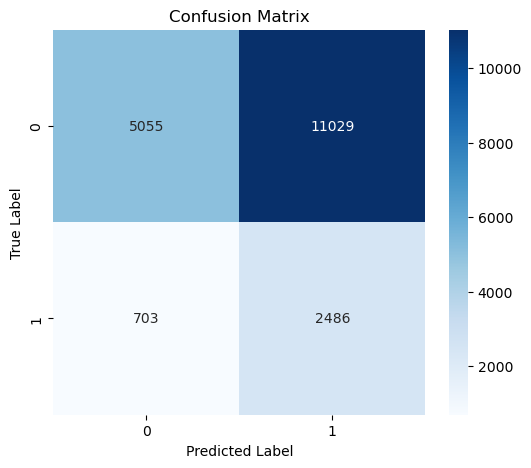

✓ Model saved to: models/final_risk_model.pkl

=== PIPELINE COMPLETED SUCCESSFULLY ===


In [98]:
# ============================================================================
# 6. FINAL TEST EVALUATION
# ============================================================================
print("\n=== FINAL EVALUATION ON TEST SET ===")

mu.evaluate_final_model(
    calibrated_model,
    X_test_processed,
    y_test,
    threshold=best_threshold
)

# Lưu model cuối cùng
mu.save_model(calibrated_model, 'models/final_risk_model.pkl')
print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")


=== BUSINESS IMPACT SIMULATION (PERCENTILE STRATEGY) ===
Dynamic Thresholds Calculated:
  RED Zone (Top 5%): Score >= 0.3938
  YELLOW Zone (Next 45%): 0.1597 <= Score < 0.3938

HIỆU QUẢ CỦA CHIẾN LƯỢC ĐỘNG:
            Tier  Total_Orders  Bad_Reviews_Found Precision Capture_Rate
  RED (Critical)          1227                360    29.34%       11.29%
YELLOW (Warning)          9506               1748    18.39%       54.81%
    GREEN (Safe)          8540               1081    12.66%       33.90%


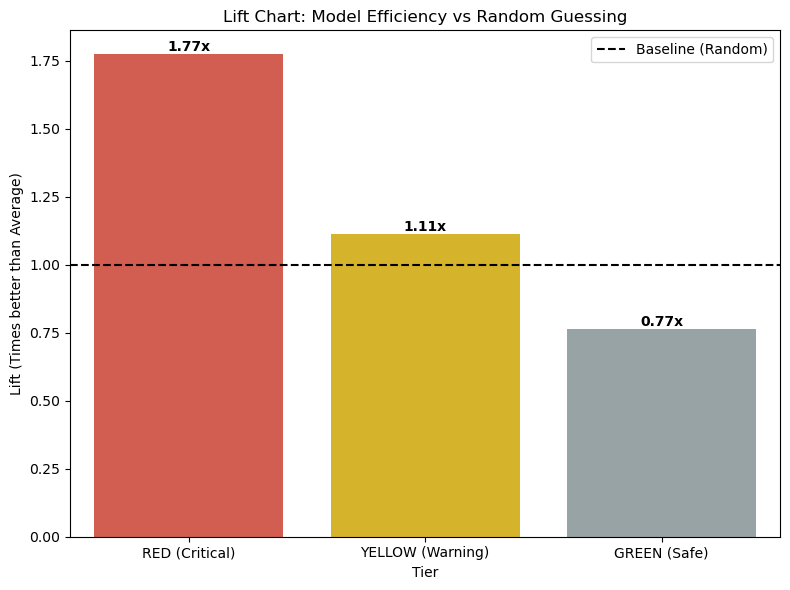

In [99]:
# ============================================================================
# 7. BUSINESS VALUE & RISK STRATIFICATION (DYNAMIC PERCENTILES)
# ============================================================================
print("\n=== BUSINESS IMPACT SIMULATION (PERCENTILE STRATEGY) ===")

tier_summary, df_results, high_th, low_th = mu.simulate_dynamic_tiered_strategy(
    calibrated_model,
    X_test_processed,
    y_test,
    red_percentile=95,
    yellow_percentile=50
)
print("\nHIỆU QUẢ CỦA CHIẾN LƯỢC ĐỘNG:")
print(tier_summary.to_string(index=False, formatters={
    'Precision': '{:.2%}'.format,
    'Capture_Rate': '{:.2%}'.format
}))

# --- VISUALIZATION  ---

# vu.plot_business_impact(df_results, tier_summary);

# Phase CLUSTERING

In [100]:
# ============================================================================
# PHASE 3: CLUSTERING & SEGMENTATION PIPELINE
# ============================================================================
print("\n=== CLUSTERING PIPELINE ===")

# 1. Feature Selection
clustering_features = [
    'total_price', 'total_freight', 'freight_ratio', 'distance_km',
    'product_photos_qty', 'product_description_lenght', 'product_weight_g'
]
X_cluster = X_train_processed[clustering_features].copy()


=== CLUSTERING PIPELINE ===


PCA Computed. Explained Variance (PC1+PC2): 55.56%


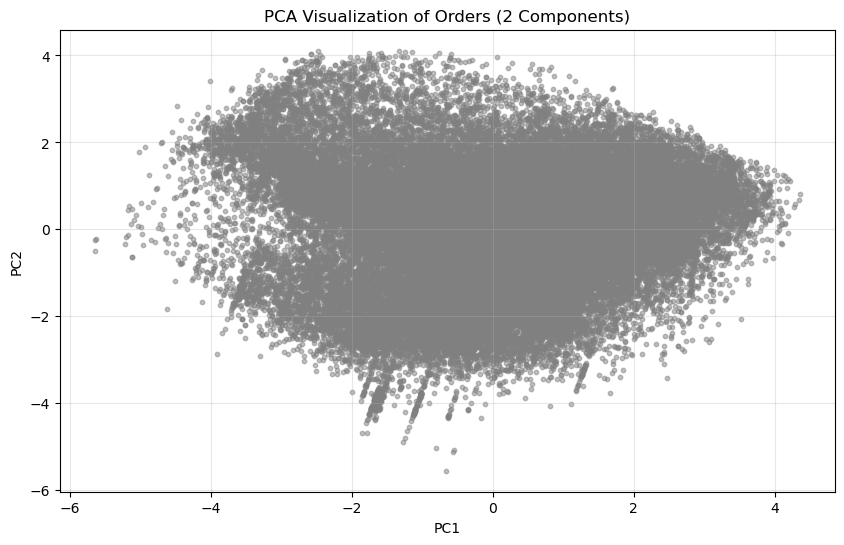

In [101]:
# 2. PCA Analysis
X_pca, pca_model = mu.run_pca_analysis(X_cluster)
vu.plot_pca_scatter(X_pca);

Running Elbow Method for K in range(2, 10)...


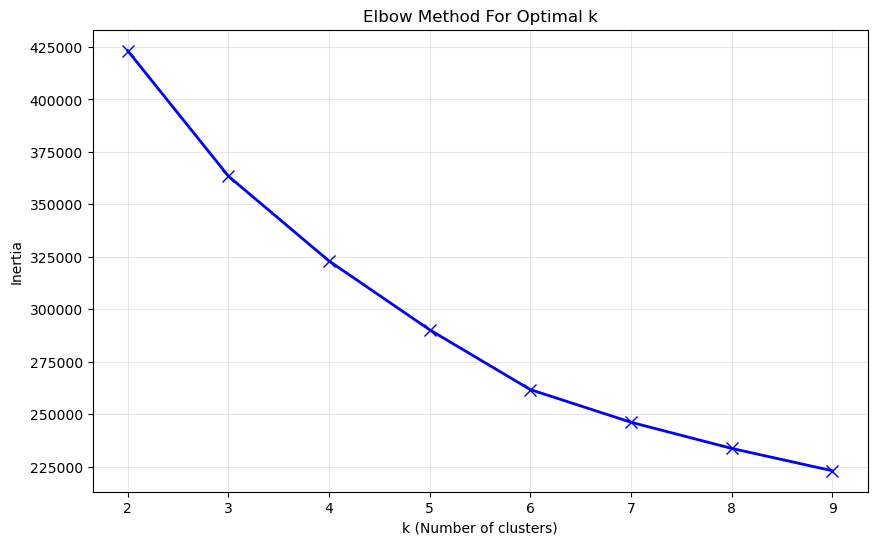

In [102]:
# 3. Elbow Method
k_range = range(2, 10)
inertia_vals = mu.compute_elbow_inertia(X_cluster, k_range)
vu.plot_elbow_curve(k_range, inertia_vals);

Fitting KMeans with k=4...

=== CLUSTER PROFILING ===


,Avg_Price,Avg_Freight,Avg_Distance,Avg_Weight,Avg_Desc_Len,Bad_Review_Rate,Order_Count,Population_%
Cluster,,,,,,,,
2,276.46,37.62,779.66,5637.91,1161.45,0.25,20051,26.0
1,29.03,20.06,803.57,465.21,583.85,0.23,13420,17.4
0,113.93,18.25,643.22,1058.89,597.43,0.22,30246,39.2
3,84.09,10.42,68.98,1111.75,758.37,0.17,13371,17.3


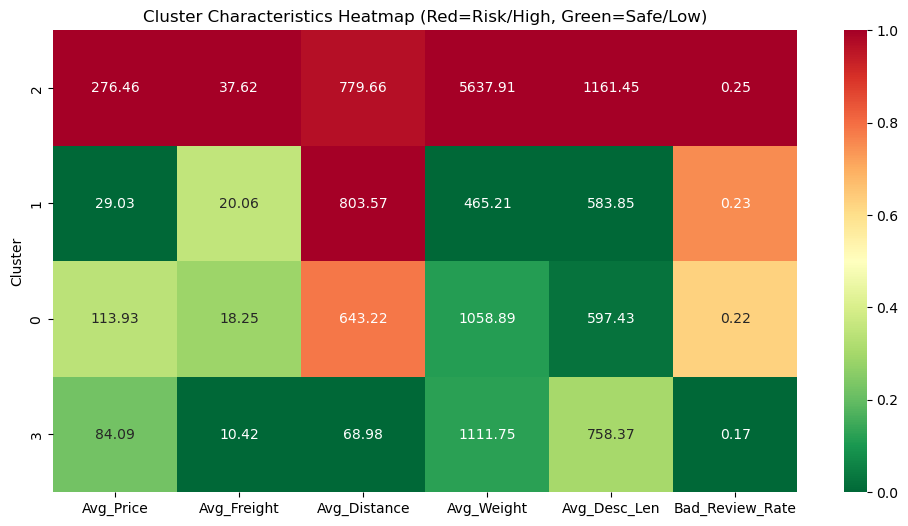

In [103]:
# 4. K-Means Fit & Profiling (Chọn K=4 dựa trên Elbow)
optimal_k = 4
kmeans_model, cluster_labels = mu.fit_kmeans_model(X_cluster, n_clusters=optimal_k)

# Tạo Profile Report
profile_df = mu.create_cluster_profile(
    X_processed=X_cluster,
    train_df_raw=train_df, # Dùng bản gốc để lấy giá trị thật
    y_train=y_train,
    labels=cluster_labels
)

print("\n=== CLUSTER PROFILING ===")
display(profile_df)
vu.plot_cluster_heatmap(profile_df);

In [104]:
# 5. Save Model
mu.save_model(kmeans_model, 'models/kmeans_cluster_model.pkl')

✓ Model saved to: models/kmeans_cluster_model.pkl


# Full phase 3 hybird

In [105]:
# ============================================================================
# PHASE 3: HYBRID MODELING LOOP
# ============================================================================
print("\n=== HYBRID MODELING PIPELINE ===")


=== HYBRID MODELING PIPELINE ===


In [106]:
# 1. Feature Integration
X_train_final, X_test_final = fu.prepare_hybrid_data(
    X_train_processed, X_test_processed, kmeans_model, clustering_features
)
# 2. Train Hybrid Model (Full Pipeline)
best_params = final_model.get_params()
hybrid_calibrated, best_thresh_hybrid = mu.train_hybrid_pipeline(
    X_train_final, y_train, best_params, val_size=0.15
)

Integrating Cluster Features (Input Train: (77088, 36))...
✓ Hybrid Data Ready - Train: (77088, 40), Test: (19273, 40)

Starting Hybrid Training Pipeline...
  Split: Train_Sub (65524, 40) | Val (11564, 40)
  Fitting Base Model (LogisticRegression)...
  Calibrating Model...
  Optimizing Threshold (F2)...
✓ Hybrid Training Done. Optimal Threshold: 0.11



FINAL TEST RESULTS (Threshold=0.11)
              precision    recall  f1-score   support

           0       0.88      0.23      0.36     16084
           1       0.18      0.85      0.30      3189

    accuracy                           0.33     19273
   macro avg       0.53      0.54      0.33     19273
weighted avg       0.77      0.33      0.35     19273

ROC AUC: 0.5900
F2 Score: 0.4857


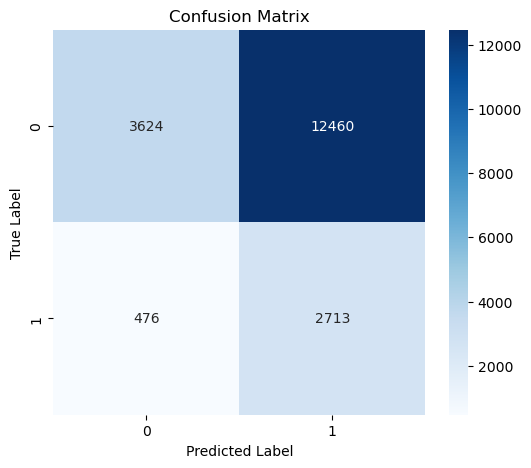

In [107]:
# 3. Final Evaluation
mu.evaluate_final_model(hybrid_calibrated, X_test_final, y_test, threshold=best_thresh_hybrid)


Dynamic Thresholds Calculated:
  RED Zone (Top 5%): Score >= 0.3972
  YELLOW Zone (Next 45%): 0.1640 <= Score < 0.3972

=== HYBRID BUSINESS IMPACT ===
            Tier  Total_Orders  Bad_Reviews_Found Precision Capture_Rate
  RED (Critical)           994                310    31.19%        9.72%
YELLOW (Warning)          9693               1786    18.43%       56.01%
    GREEN (Safe)          8586               1093    12.73%       34.27%


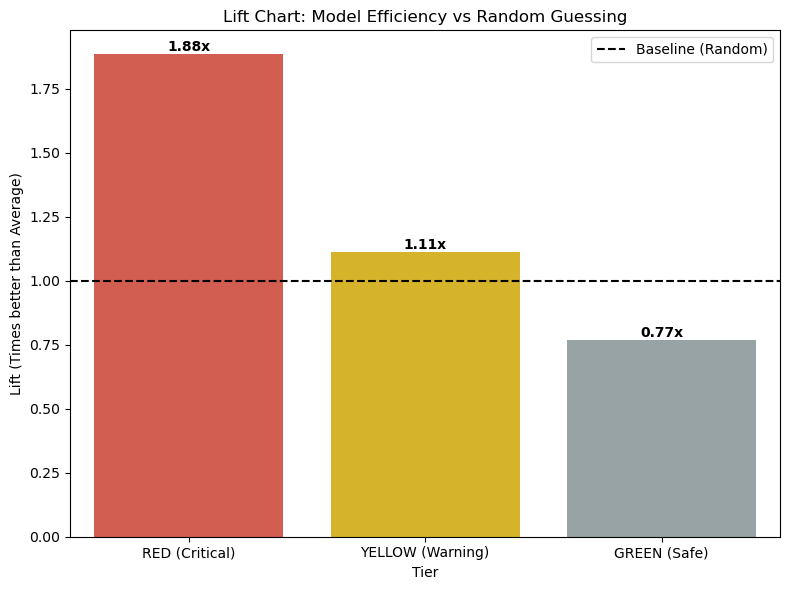

In [114]:
# 4. Business Impact (Dynamic Tiering)
tier_summary_h, df_results_h, high_th_h, low_th_h = mu.simulate_dynamic_tiered_strategy(
    hybrid_calibrated, X_test_final, y_test,
    red_percentile=95, yellow_percentile=50
)

print("\n=== HYBRID BUSINESS IMPACT ===")
print(tier_summary_h.to_string(index=False, formatters={'Precision': '{:.2%}'.format, 'Capture_Rate': '{:.2%}'.format}))
vu.plot_business_impact(df_results_h, tier_summary_h);


In [109]:
mu.save_model(hybrid_calibrated, 'models/final_hybrid_model.pkl')

✓ Model saved to: models/final_hybrid_model.pkl


In [110]:
# 1. Lưu Thresholds và Stats quan trọng
model_config = {
    "thresholds": {
        "high_risk": float(high_th_h),
        "low_risk": float(low_th_h)
    },
    "features": {
        "all_features": list(X_train_final.columns),
        "skewed_cols": skewed_cols,
        "categorical_cols": categorical_cols,
        "clustering_features": clustering_features
    },
    "metrics": {
        "auc": 0.5900,
        "precision_red": 0.3119
    }
}

with open('models/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=4)
print("✓ Saved model configuration to 'models/model_config.json'")



✓ Saved model configuration to 'models/model_config.json'


In [111]:
def assign_action_plan(df_input, risk_col='risk_score', cluster_col='Cluster',
                       high_th=0.40, low_th=0.16):
    """
    Ánh xạ Risk Score & Cluster thành Hành động cụ thể (Action Matrix).

    Logic Matrix:
    - RED ZONE (>= high_th):
        + VIP (Cluster 2) -> GỌI ĐIỆN TRỰC TIẾP (Ưu tiên 1)
        + Price Sensitive (Cluster 1) -> GỬI SMS + VOUCHER (Tự động)
        + Còn lại (0, 3) -> EMAIL CẢNH BÁO GIAO HÀNG
    - YELLOW ZONE (>= low_th):
        + VIP (Cluster 2) -> EMAIL CHĂM SÓC CÁ NHÂN
        + Còn lại -> APP NOTIFICATION (Tự động)
    - GREEN ZONE: Không hành động
    """
    df = df_input.copy()

    # 1. Định nghĩa điều kiện (Vectorized cho tốc độ cao)
    cond_red = df[risk_col] >= high_th
    cond_yellow = (df[risk_col] >= low_th) & (df[risk_col] < high_th)

    # 2. Tạo cột Action & Priority
    conditions = [
        # --- RED ZONE ---
        cond_red & (df[cluster_col] == 2),  # VIP -> Call
        cond_red & (df[cluster_col] == 1),  # Low Val -> SMS
        cond_red,                           # Others -> Email Urgent

        # --- YELLOW ZONE ---
        cond_yellow & (df[cluster_col] == 2), # VIP -> Personal Email
        cond_yellow,                          # Others -> App Notify
    ]

    actions = [
        'CALL_PRIORITY_1',
        'SMS_VOUCHER_AUTO',
        'EMAIL_URGENT',
        'EMAIL_PERSONAL_CARE',
        'APP_PUSH_NOTIFY'
    ]

    channels = ['Phone', 'SMS', 'Email', 'Email', 'App']

    # Gán giá trị (Default là NO_ACTION)
    df['Action'] = np.select(conditions, actions, default='NO_ACTION')
    df['Channel'] = np.select(conditions, channels, default='None')

    return df

def estimate_daily_workload(action_df, days_in_test=90):
    """Tính toán khối lượng công việc trung bình mỗi ngày cho team CSKH"""

    # Định mức thời gian xử lý (giả định)
    effort_map = {
        'CALL_PRIORITY_1': 15,      # 15 phút/cuộc
        'EMAIL_PERSONAL_CARE': 5,   # 5 phút/mail
        'EMAIL_URGENT': 2,          # 2 phút review
        'SMS_VOUCHER_AUTO': 0,      # 0 phút (Auto)
        'APP_PUSH_NOTIFY': 0,       # 0 phút (Auto)
        'NO_ACTION': 0
    }

    summary = action_df.groupby('Action').size().reset_index(name='Total_Volume')
    summary['Daily_Volume'] = (summary['Total_Volume'] / days_in_test).round(1)
    summary['Mins_Per_Action'] = summary['Action'].map(effort_map)
    summary['Daily_Man_Hours'] = (summary['Daily_Volume'] * summary['Mins_Per_Action'] / 60).round(2)

    # Sắp xếp theo mức độ ưu tiên thủ công
    return summary.sort_values('Daily_Man_Hours', ascending=False)

In [112]:
# ========================================================
# EXECUTION BLOCK
# ========================================================
X_test_cluster_input = X_test_processed[clustering_features].copy()
test_cluster_labels = kmeans_model.predict(X_test_cluster_input)

# 1. Chuẩn bị dữ liệu (Lấy lại Cluster ID từ One-Hot nếu cần, hoặc dùng labels có sẵn)
# 'cluster_labels' là array [0, 2, 1...] từ bước trước
simulation_df = X_test_final.copy()
simulation_df['Cluster'] = test_cluster_labels  # Gán nhãn vừa dự đoán
simulation_df['risk_score'] = hybrid_calibrated.predict_proba(X_test_final)[:, 1]
simulation_df['actual_target'] = y_test.values
# 2. Chạy Action Mapping
action_plan_df = assign_action_plan(
    simulation_df,
    high_th=0.3972,
    low_th=0.1640
)

In [113]:
# 3. Xuất báo cáo
print("\n=== [PHASE 4] FINAL ACTIONABLE FRAMEWORK ===")
workload_report = estimate_daily_workload(action_plan_df)

print("\n1. Kế hoạch phân bổ nguồn lực (Daily Estimates):")
print(workload_report.to_string(index=False))

print("\n2. Mẫu danh sách khách hàng cần ưu tiên (Top 5 High Risk):")
cols_show = ['risk_score', 'Cluster', 'Action', 'Channel']
print(action_plan_df.sort_values('risk_score', ascending=False)[cols_show].head(5))


=== [PHASE 4] FINAL ACTIONABLE FRAMEWORK ===

1. Kế hoạch phân bổ nguồn lực (Daily Estimates):
             Action  Total_Volume  Daily_Volume  Mins_Per_Action  Daily_Man_Hours
EMAIL_PERSONAL_CARE          2946          32.7                5             2.72
    CALL_PRIORITY_1           313           3.5               15             0.88
       EMAIL_URGENT           391           4.3                2             0.14
    APP_PUSH_NOTIFY          6940          77.1                0             0.00
          NO_ACTION          8586          95.4                0             0.00
   SMS_VOUCHER_AUTO            97           1.1                0             0.00

2. Mẫu danh sách khách hàng cần ưu tiên (Top 5 High Risk):
       risk_score  Cluster           Action Channel
16089    0.688825        2  CALL_PRIORITY_1   Phone
11438    0.606267        2  CALL_PRIORITY_1   Phone
12371    0.587431        2  CALL_PRIORITY_1   Phone
12769    0.586957        2  CALL_PRIORITY_1   Phone
7259     0